In [1]:
import pandas as pd
import os
import glob

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO
import panel as pn
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot
from bokeh.io import export_svg, output_notebook, install_notebook_hook, notebook
import numpy as np
import re
import seaborn as sb

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

def merge_windows(wins):
    a = [wins[0]]
    for i in range(len(wins)-1):
        prev = a[len(a)-1]
        next = wins[i+1]
        if prev[1] + 1 >= next[0]:
            a[len(a)-1] = (a[len(a)-1][0], next[1])
        else:
            a.append(next)
    return a

def read_identity(path, ref):
    df = pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,1,2,3,4], header=None)
    df.columns = ["seq1", "seq2", "identity", "nid", "denom"]
    idx1 = df["seq1"].str.contains(ref)
    idx2 = df["seq2"].str.contains(ref)
    df = df[idx1 | idx2]
    idx = (df["seq2"].str.contains(ref))
    # put all references to the seq2 column
    df.loc[idx, ["seq1", "seq2"]] = df.loc[idx, ["seq2", "seq1"]].values
    df["seq2"] = df["seq2"].map(lambda x: x.split("|")[1])
    df = df.drop(columns=["seq1"]).set_index("seq2")
    return dict(zip(df.index, df.identity))

def read_stride(path):
    data = []
    with open(path, "r") as f:
        for line in f.readlines():
            if line[:3] == "ASG":
                data.append(re.split("\s+", line)[6])
    return data

def read_safe_sequences(safety_path, stride_path):
    safe_sequences = []
    raw = ""
    with open(safety_path, "r") as f:
        raw = ("\n" + f.read()).split("\n>")[1:]
    ref_accession = raw[0].split("\n")[0].split(" ")[0].strip().split("|")[1]
    ref = raw[0].split("\n")[1].strip()

    for data in raw[1:]:
        splitted = data.split("\n")
        accession = splitted[0].split(" ")[0].split("|")[1]
        seq = splitted[1].strip()
        rwindows = []
        swindows = []
        for line in splitted[3:]:
            ends = line.split()
            if len(ends) != 4:
                continue
            rwindows.append((int(ends[0]), int(ends[1])))
            swindows.append((int(ends[2]), int(ends[3])))
        rwindows = merge_windows(rwindows)
        swindows = merge_windows(swindows)
        safe_sequences.append(SafeSequence(accession, seq, rwindows, swindows, stride_path))
        
    return (ref, ref_accession, safe_sequences)

In [3]:
def get_colors(seqs, longest):
    """make colors for bases in sequence"""
    colors = []
    for ss in seqs:
        colors += ss.get_stride_colors(longest)
        colors += ss.get_safety_window_colors(longest)
    colors += ["white" for i in range(longest)]
    return colors

def get_columns(ref, seqs, longest):
    text = ""
    for ss in seqs:
        s = ss.sequence + (" " * (longest - len(ss.sequence)))
        text += ss.get_strides() + (" " * (longest - len(ss.sequence)))
        text += s
    text += ref + (" " * (longest - len(ref)))
    return list(text)

In [4]:
clrs = ["steelblue"]
flex = ["Coil", "Strand", "Turn"]
acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V", "U", "O"]

class SafeSequence():
    def __init__(self, accession, sequence, ref_windows, seq_windows, stride_path):
        self.accession = accession
        self.sequence = sequence
        self.identity = 0.0
        self.ref_windows = ref_windows
        self.seq_windows = seq_windows
        self.safe_bases = 0
        self.stable_bases = 0
        self.strides = self.read_strides(stride_path)
        self.TP, self.TN, self.FP, self.FN = 0,0,0,0
        self.calculate_hits()
        if self.TP + self.FP == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.precision = 0
        else: 
            self.precision = self.TP / max(self.TP + self.FP, 1)
        if self.TP + self.FN == 0:
            # print(f"{self.TP}, {self.FP}, {self.TN}, {self.FN}")
            self.recall = 0
        else:
            self.recall = self.TP / max(self.TP + self.FN, 1)

        # base distribution in the sequence
        # self.safe_distribution = {}
        # self.non_safe_distribution = {}
        # self.distribution = {}
        # for acid in acids:
        #     self.distribution[acid] = 0
        #     self.safe_distribution[acid] = 0
        #     self.non_safe_distribution[acid] = 0
        # self.calculate_distributions()

    def calculate_hits(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            stable = self.is_stable(i)
            self.safe_bases += safe
            self.stable_bases += stable
            self.TP += safe and stable
            self.TN += not safe and not stable
            self.FP += safe and not stable
            self.FN += not safe and stable
        assert self.TP + self.TN + self.FP + self.FN == len(self.sequence), f"Hits do not match"

    def calculate_distributions(self):
        for i in range(len(self.sequence)):
            safe = self.is_safe(i)
            aa = self.sequence[i]
            self.distribution[aa] += 1
            self.safe_distribution[aa] += safe
            self.non_safe_distribution[aa] += not safe

    def is_safe(self, i):
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            if i >= start and i <= end:
                return True
        return False

    def is_stable(self, i):
        return self.strides[i] not in flex

    def get_safety_window_colors(self, longest):
        colors = ["white"] * longest
        clr = 0
        for window in self.seq_windows:
            start = window[0]
            end = window[1]
            for i in range(start, end):
                colors[i] = clrs[clr % len(clrs)]
            
            clr += 1
        return colors

    def get_stride_colors(self, longest):
        colors = []
        for stride in self.strides:
            if stride not in flex:
                colors.append("palegreen")
            else:
                colors.append("white")
        
        return colors + (["white"] * (longest - len(self.sequence)))

    def get_strides(self):
        return "".join([stride[0] for stride in self.strides])

    def read_strides(self, path):
        return read_stride(f"{path}/{self.accession}.out")

class Cluster():
    def __init__(self, safe_path, stride_path, id_path):
        self.ref_seq, self.ref_accession, self.sequences = read_safe_sequences(safe_path, stride_path)
        identity_df = read_identity(id_path, self.ref_accession)
        for ss in self.sequences:
            ss.identity = identity_df[ss.accession]
        del(identity_df)
        self.precision, self.recall = self.get_precision_recall()
        self.avg_safe_coverage = self.get_safe_coverage()
        self.avg_stable_coverage = self.get_stable_coverage()

    def get_precision_recall(self):
        tp, fp, tn, fn = 0,0,0,0
        for ss in self.sequences:
            tp += ss.TP
            fp += ss.FP
            tn += ss.TN
            fn += ss.FN
        return (tp/(tp+fp), tp/(tp+fn))

    def get_safe_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.safe_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def get_stable_coverage(self):
        coverage = 0.0
        for ss in self.sequences:
            coverage += (ss.stable_bases / len(ss.sequence))
        coverage /= len(self.sequences)
        return coverage

    def plot_windows(self):
        longest = len(self.ref_seq)
        for ss in self.sequences:
            longest = max(len(ss.sequence), longest)

        text = get_columns(self.ref_seq, self.sequences, longest)
        colors = get_colors(self.sequences, longest)
        cols = longest
        rows = len(self.sequences)*2+1
        x = np.arange(1, cols + 1)
        y = np.arange(0, rows, 1)
        xx, yy = np.meshgrid(x, y)
        gx = xx.ravel()
        gy = yy.flatten()
        recty = gy + 0.5
        d = dict(x=gx, y=gy, recty=recty, text=text, colors=colors)
        source = ColumnDataSource(d)
        plot_height = rows * 15
        plot_width = longest * 15
        x_range = Range1d(0, cols + 1, bounds='auto')

        rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors", line_color=None, fill_alpha=0.8)
        glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black", text_font_size="4pt")
        
        p = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=(0,rows),
                min_border=0, toolbar_location='below')
        p.add_glyph(source, rects)
        p.add_glyph(source, glyph)    
        p = gridplot([[p]])

        return p

In [5]:
def calc_ratios(safe_path, stride_path):
    ref, ref_accession, safe_sequences = read_safe_sequences(safe_path, stride_path)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for ss in safe_sequences:
        tp += ss.TP
        fp += ss.FP
        tn += ss.TN
        fn += ss.FN
    return (tp/(tp+fp), tp/(tp+fn))

def call_all(work_dir, alpha, delta):
    ps = []
    rs = []
    safety_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "*.out")))
    stride_files = sorted(filter(os.path.isdir, glob.glob(os.path.join(work_dir, "stride", "*"))))
    
    # for i in range(len(safety_files)):
    #     print(f"{safety_files[i].split('/')[-1]} - {stride_files[i].split('/')[-1]}")

    assert len(safety_files) == len(stride_files), f"{safety_files}\n\n{stride_files}"
    
    z = list(zip(safety_files, stride_files))
    for file in tqdm(z):
        p, r = calc_ratios(file[0], file[1])
        ps.append(p)
        rs.append(r)
    return (ps, rs)

In [31]:
def get_clusters(work_dir, alpha, delta):
    safety_files = sorted(glob.glob(os.path.join(work_dir, f"safety.a{alpha}.d{delta}", "*.out")))
    identity_files = sorted(glob.glob(os.path.join(work_dir, "id", "*.out")))
    stride_files = sorted(filter(os.path.isdir, glob.glob(os.path.join(work_dir, "stride", "*"))))
    
    assert len(safety_files) == len(stride_files) and len(identity_files) == len(safety_files), f"Not proper file count {len(safety_files)} {len(identity_files)} {len(stride_files)}"
    
    z = list(zip(safety_files, stride_files, identity_files))
    clusters = []
    for file in tqdm(z):
        clusters.append(Cluster(file[0], file[1], file[2]))
    return clusters


100%|██████████| 473/473 [09:55<00:00,  1.26s/it]


In [35]:
a75d0 = get_clusters("./../out/sprot_filtered.40.multi-step", 75, 0)
a75d5 = get_clusters("./../out/sprot_filtered.40.multi-step", 75, 5)

100%|██████████| 473/473 [10:10<00:00,  1.29s/it]


In [36]:
hp_clusters = [cluster for cluster in a75d0 if cluster.precision > 0.8]
lp_clusters = [cluster for cluster in a75d0 if cluster.precision < 0.2]

In [43]:
show(lp_clusters[3].plot_windows())
print(lp_clusters[3].ref_accession)

Q32RM0


In [44]:
show(hp_clusters[15].plot_windows())
print(hp_clusters[15].ref_accession)

Q32GU0


In [74]:
show(a75d5[29].plot_windows())

In [19]:
show([cluster for cluster in all_clusters if cluster.avg_safe_coverage < 0.9][0].plot_windows())

In [75]:
def get_metrics(clusters):
    safe_coverage = []
    stable_coverage = []
    precision = []
    recall = []
    identity = []
    refs = []
    ids = []
    for cluster in clusters:
        for ss in cluster.sequences:
            refs.append(cluster.ref_accession)
            ids.append(ss.accession)
            identity.append(ss.identity)
            recall.append(ss.recall)
            precision.append(ss.precision)
            safe_coverage.append(ss.safe_bases / len(ss.sequence))
            stable_coverage.append(ss.stable_bases / len(ss.sequence))

    return pd.DataFrame(
        data={"ref":refs, "id":ids, "identity":identity,
        "recall":recall, "precision":precision,
        "safe_coverage": safe_coverage, "stable_coverage": stable_coverage})

df = get_metrics(a75d5)
lp_df = get_metrics(lp_clusters)
hp_df = get_metrics(hp_clusters)
df.head()

,ref,id,identity,recall,precision,safe_coverage,stable_coverage
0,B8NLM9,P93207,69.33,0.934272,0.888393,0.888889,0.845238
1,B8NLM9,Q9U408,52.52,0.974227,0.866972,0.893443,0.795082
2,B8NLM9,Q24902,53.36,0.979487,0.872146,0.897541,0.799180
3,B8NLM9,P42648,64.71,0.995192,0.873418,0.991632,0.870293
4,B8NLM9,Q26540,55.04,0.920188,0.875000,0.888889,0.845238


In [76]:
df.corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)

/var/folders/x4/2b03rv452rqdbtftqhjj0d340000gn/T/ipykernel_1471/2144169796.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


,identity,recall,precision,safe_coverage,stable_coverage
identity,1.00,0.17,-0.10,0.46,-0.10
recall,0.17,1.00,0.29,0.37,0.26
precision,-0.10,0.29,1.00,-0.06,0.99
safe_coverage,0.46,0.37,-0.06,1.00,-0.04
stable_coverage,-0.10,0.26,0.99,-0.04,1.00


In [77]:
df[df["identity"] < 40].corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)

/var/folders/x4/2b03rv452rqdbtftqhjj0d340000gn/T/ipykernel_1471/4197863377.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df[df["identity"] < 40].corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


,identity,recall,precision,safe_coverage,stable_coverage
identity,1.00,0.14,-0.02,0.21,-0.03
recall,0.14,1.00,0.25,0.40,0.17
precision,-0.02,0.25,1.00,0.04,0.99
safe_coverage,0.21,0.40,0.04,1.00,0.04
stable_coverage,-0.03,0.17,0.99,0.04,1.00


In [110]:
df[df["identity"] > 70].corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


/var/folders/x4/2b03rv452rqdbtftqhjj0d340000gn/T/ipykernel_1736/3536419858.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df[df["identity"] > 70].corr(method="pearson").style.background_gradient(cmap="coolwarm").set_precision(2)


,identity,recall,precision,safe_coverage,stable_coverage
identity,1.00,0.04,0.16,0.06,0.16
recall,0.04,1.00,0.13,0.24,0.12
precision,0.16,0.13,1.00,0.04,1.00
safe_coverage,0.06,0.24,0.04,1.00,0.03
stable_coverage,0.16,0.12,1.00,0.03,1.00


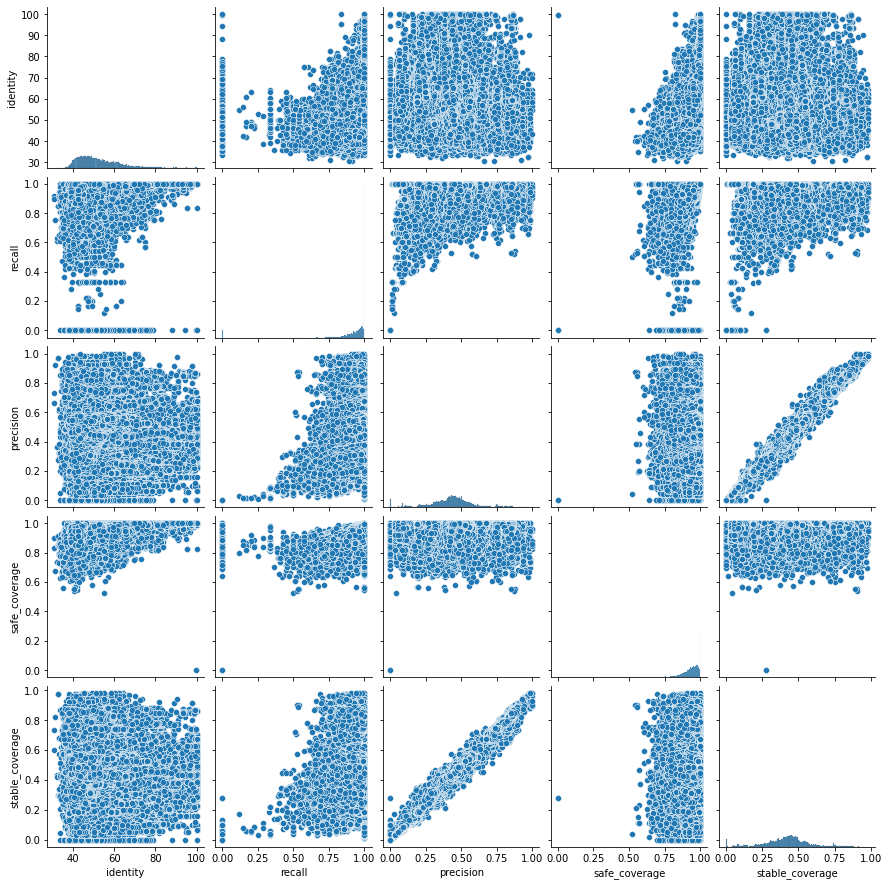

In [78]:
sb.pairplot(df)

In [79]:
def plot_metrics(clusters, desc):
    safe_coverage = []
    stable_coverage = []
    precision = []
    recall = []
    for cluster in clusters:
        safe_coverage.append(cluster.avg_safe_coverage)
        stable_coverage.append(cluster.avg_stable_coverage)
        precision.append(cluster.precision)
        recall.append(cluster.recall)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
    fig.suptitle(desc)
    axes[0][0].hist(precision, bins=30)
    axes[0][0].set_title(f"Precision")
    axes[0][0].axis(xmin=0, xmax=1)

    axes[0][1].hist(recall, bins=30)
    axes[0][1].set_title(f"Recall")
    axes[0][1].axis(xmin=0, xmax=1)

    axes[1][0].hist(safe_coverage, bins=30)
    axes[1][0].set_title(f"SW Coverage")
    axes[1][0].axis(xmin=0, xmax=1)

    axes[1][1].hist(stable_coverage, bins=30)
    axes[1][1].set_title(f"Stable Structure Coverage")
    axes[1][1].axis(xmin=0, xmax=1)
    plt.show()


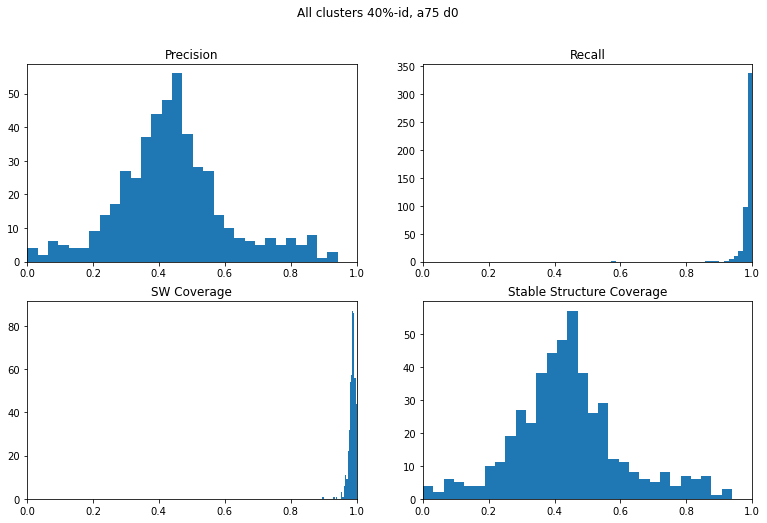

In [33]:
plot_metrics(all_clusters, "All clusters 40%-id, a75 d0")